# Assignment 10 - MNIST Digit Prediction and Model Deployment with MLFlow

## 1. Data Preprocessing

We start by importing all the necessary libraries

In [70]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,precision_recall_curve,average_precision_score,roc_curve,roc_auc_score
)
from sklearn.metrics import root_mean_squared_error
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from mlflow.models import infer_signature


# Machine learning models
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# MLflow imports
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

# For handling requests
import requests

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# For JSON handling
import json

# set this to the remote server (where the MLflow server is running)
MLFLOW_TRACKING_URI = 'http://131.247.92.12:5013'

# Set the MLflow server
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
import os
os.environ['MLFLOW_TRACKING_USERNAME'] = 'pranaytalluri'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '073376'

### 1.1 Load MNIST Dataset

In [93]:
from sklearn.datasets import fetch_openml

# Fetch the MNIST dataset from OpenML as DataFrames
mnist = fetch_openml('mnist_784', version=1, as_frame=True)
X, y = mnist.data[:20000], mnist.target[:20000]

# Display the shapes to verify
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
X

Shape of X: (20000, 784)
Shape of y: (20000,)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.2  Data Scaling and Split

In [94]:

# Scale the data to improve training performance
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape


((16000, 784), (4000, 784))

## 2. Model Development and MLFlow Tracking

 ### Set MLFlow Experiment

In [73]:
# Define the experiment name
experiment_name = "mnist_experiment_version_1.0"

# Set the experiment
mlflow.set_experiment(experiment_name)

2024/11/03 19:12:32 INFO mlflow.tracking.fluent: Experiment with name 'mnist_experiment_version_1.0' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/8', creation_time=1730679152965, experiment_id='8', last_update_time=1730679152965, lifecycle_stage='active', name='mnist_experiment_version_1.0', tags={}>

### 2.1 MLPClassifier

#### We develop and evaluate an **MLPClassifier** model with MLFlow tracking. Autologging is disabled to enable manual control over parameter and metric logging. The model is initialized with a single hidden layer, `tanh` activation function, `adam` solver, and a maximum of 500 iterations. After training the model on the MNIST dataset, we log key metrics, including accuracy, precision, and recall, as well as artifacts like the confusion matrix and lift and gains charts to assess model performance. 

In [74]:

# Disable autologging to prevent conflicts
mlflow.sklearn.autolog(disable=True)

# Initialize the classifier
mlp = MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', solver='adam', max_iter=500)

# Start a new MLflow run
with mlflow.start_run(run_name="MLPClassifier - MNIST") as run:
    # Log model hyperparameters manually
    mlflow.log_param("hidden_layer_sizes", mlp.hidden_layer_sizes)
    mlflow.log_param("activation", mlp.activation)
    mlflow.log_param("solver", mlp.solver)
    mlflow.log_param("max_iter", mlp.max_iter)

    # Train the model
    mlp.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = mlp.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(ax=ax)
    plt.title("MLPClassifier Confusion Matrix")

    # Save and log confusion matrix plot as an artifact
    confusion_matrix_file = "confusion_matrix_mlp.png"
    plt.savefig(confusion_matrix_file)
    plt.close()
    mlflow.log_artifact(confusion_matrix_file)

    #Get predicted probabilities using mlp
    MLPC_probs = mlp.predict_proba(X_test)[:, 1]
        
    # Function to calculate lift and cumulative gain data
    def calculate_lift_and_gains(y_true, pred_probs):
        y_true = y_true.astype(int)
        data = pd.DataFrame({'true': y_true, 'pred_prob': pred_probs})
        data = data.sort_values(by='pred_prob', ascending=False).reset_index(drop=True)
        # Calculate cumulative gains
        data['cumulative_true'] = data['true'].cumsum()
        data['cumulative_gain'] = data['cumulative_true'] / data['true'].sum()
        # Deciles for lift chart
        total_positives = data['true'].sum()
        data['decile'] = pd.qcut(data.index, 10, labels=False)
        lift = data.groupby('decile')['true'].sum() / (total_positives / 10)
    
        return lift, data['cumulative_gain']
    
    # Calculate lift and gains for MLP Classifier
    MLPC_lift, MLPC_gains = calculate_lift_and_gains(y_test, MLPC_probs)
        
    # Plot lift and gains charts
    plt.figure(figsize=(12, 6))
        
    # Lift Chart for MLP Classifier
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), MLPC_lift, marker='o')  # Decile numbers (1-10)
    plt.title("Lift Chart - MLP Classifier")
    plt.xlabel("Decile")
    plt.ylabel("Lift")
    plt.grid(True)
        
    # Gains Chart for MLP Classifier
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(MLPC_gains)) / len(MLPC_gains), MLPC_gains, marker='o', label="Model Gains")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")
    plt.title("Gains Chart - MLP Classifier")
    plt.xlabel("Fraction of Total Population")
    plt.ylabel("Cumulative Gain")
    plt.legend()
    plt.grid(True)
        
    lift_gain_chart = "lift_gain_charts.png"
    plt.tight_layout()
    plt.savefig(lift_gain_chart)
    plt.close()
        
    mlflow.log_artifact(lift_gain_chart)
    

    # Log the model itself
    mlflow.sklearn.log_model(mlp, "mlp_model")
    mlflow.end_run()
 
    print("MLflow run completed. Check your MLflow UI for logged metrics and artifacts.")

2024/11/03 19:12:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/03 19:12:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run MLPClassifier - MNIST at: http://131.247.92.12:5013/#/experiments/8/runs/ed134baa6ec04a8eb7a4e72c546bbce4.
2024/11/03 19:12:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5013/#/experiments/8.


MLflow run completed. Check your MLflow UI for logged metrics and artifacts.


### 2.2 Logistic Regression

#### We develop and evaluate a **Logistic Regression** model with MLFlow tracking. Autologging is disabled to allow manual control over logging. The model is initialized with a hyperparameter grid, including regularization strength (`C`), penalty type (`l1` or `l2`), and solver options. We use `RandomizedSearchCV` to optimize these parameters over 10 random samples. The best model's hyperparameters and metrics (accuracy, precision, recall) are logged, alongside artifacts like the confusion matrix, lift chart, and gains chart for a complete evaluation. 

In [75]:
# Disable autologging to prevent conflicts
mlflow.sklearn.autolog(disable=True)

log_reg = LogisticRegression(max_iter=500)

# Define the parameter grid
param_grid = {
    'C': [0.1,1,10],
    'penalty': ['l2', 'l1'],
    'solver': ['saga', 'liblinear'],
}

# Set up RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Start a new run
with mlflow.start_run(run_name="Logistic Regression- manual") as run:
    
    # Perform random search
    random_search.fit(X_train, y_train)
    
    # Log the best hyperparameters
    best_params = random_search.best_params_
    mlflow.log_params(best_params)
    
    # Evaluate the best model on the test set
    best_log_reg = random_search.best_estimator_
    y_pred_log_reg = best_log_reg.predict(X_test)
    
    # Calculate and log metrics
    accuracy = accuracy_score(y_test, y_pred_log_reg)
    precision = precision_score(y_test, y_pred_log_reg, average='weighted')
    recall = recall_score(y_test, y_pred_log_reg, average='weighted')
    
    # Log the best model artifact
    input_example = X_test[:5]
    signature = infer_signature(X_test, y_pred_log_reg)
    mlflow.sklearn.log_model(best_log_reg, "best_log_reg", signature=signature, input_example=input_example)
    
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    
    # Logistic Regression Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
    disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_log_reg)
    disp_log_reg.plot(ax=ax, colorbar=False)
    ax.set_title("Logistic Regression Confusion Matrix")
    
    confusion_matrix_file = "confusion_matrix.png"
    plt.tight_layout()
    plt.savefig(confusion_matrix_file)
    plt.close()
    
    mlflow.log_artifact(confusion_matrix_file)



  # Get predicted probabilities using best_log_reg
    logistic_probs = best_log_reg.predict_proba(X_test)[:, 1]
        
        # Function to calculate lift and cumulative gain data
    def calculate_lift_and_gains(y_true, pred_probs):
            y_true = y_true.astype(int)
            data = pd.DataFrame({'true': y_true, 'pred_prob': pred_probs})
            data = data.sort_values(by='pred_prob', ascending=False).reset_index(drop=True)
            # Calculate cumulative gains
            data['cumulative_true'] = data['true'].cumsum()
            data['cumulative_gain'] = data['cumulative_true'] / data['true'].sum()
            # Deciles for lift chart
            total_positives = data['true'].sum()
            data['decile'] = pd.qcut(data.index, 10, labels=False)
            lift = data.groupby('decile')['true'].sum() / (total_positives / 10)
    
            return lift, data['cumulative_gain']
        
        # Calculate lift and gains for Logistic Regression
    logistic_lift, logistic_gains = calculate_lift_and_gains(y_test, logistic_probs)
        
        # Plot lift and gains charts
    plt.figure(figsize=(12, 6))
        
        # Lift Chart for Logistic Regression
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), logistic_lift, marker='o')  # Decile numbers (1-10)
    plt.title("Lift Chart - Logistic Regression")
    plt.xlabel("Decile")
    plt.ylabel("Lift")
    plt.grid(True)
        
        # Gains Chart for Logistic Regression
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(logistic_gains)) / len(logistic_gains), logistic_gains, marker='o', label="Model Gains")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")
    plt.title("Gains Chart - Logistic Regression")
    plt.xlabel("Fraction of Total Population")
    plt.ylabel("Cumulative Gain")
    plt.legend()
    plt.grid(True)
        
    lift_gain_chart = "lift_gain_charts.png"
    plt.tight_layout()
    plt.savefig(lift_gain_chart)
    plt.close()
        
    mlflow.log_artifact(lift_gain_chart)
    mlflow.end_run()
    print("MLflow run completed. Check your MLflow UI for logged metrics and artifacts.")
    
  
    
  

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/envs/mlflow_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/mlflow_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/mlflow_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/mlflow_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/mlflow_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/mlflo

MLflow run completed. Check your MLflow UI for logged metrics and artifacts.


### 2.3 Random Forest

#### We develop and evaluate a **Random Forest** model with MLFlow tracking, disabling autologging to manage logging manually. The model is initialized with a comprehensive hyperparameter grid, including settings for the number of trees (`n_estimators`), depth (`max_depth`), and feature selection (`max_features`). Using `RandomizedSearchCV`, we optimize these parameters across 10 iterations. Metrics such as accuracy, precision, and recall are logged, alongside artifacts like the confusion matrix and lift and gains charts. 

In [76]:
# Disable autologging to prevent conflicts
mlflow.sklearn.autolog(disable=True)

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200,300],        # Number of trees in the forest
    'max_depth': [10, 20,None],            # Maximum depth of each tree
    'min_samples_split': [2, 5,],        # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']        # Number of features to consider at each split
}

# Set up RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Start a new MLflow run
with mlflow.start_run(run_name="RandomForest - manual") as run:
    
    # Perform random search
    random_search.fit(X_train, y_train)
    
    # Log the best hyperparameters
    best_params = random_search.best_params_
    mlflow.log_params(best_params)
    
    # Evaluate the best model on the test set
    best_rf = random_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    
    # Calculate and log metrics
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf, average='weighted')
    recall = recall_score(y_test, y_pred_rf, average='weighted')
    
    # Log the best model artifact
    input_example = X_test[:5]
    signature = infer_signature(X_test, y_pred_rf)
    mlflow.sklearn.log_model(best_rf, "best_rf", signature=signature, input_example=input_example)
    
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    
    # Random Forest Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
    disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
    disp_rf.plot(ax=ax, colorbar=False)
    ax.set_title("Random Forest Confusion Matrix")
    
    confusion_matrix_file = "confusion_matrix_rf.png"
    plt.tight_layout()
    plt.savefig(confusion_matrix_file)
    plt.close()
    
    mlflow.log_artifact(confusion_matrix_file)

    # Get predicted probabilities using best_rf
    rf_probs = best_rf.predict_proba(X_test)[:, 1]
        
    # Function to calculate lift and cumulative gain data
    def calculate_lift_and_gains(y_true, pred_probs):
        y_true = y_true.astype(int)
        data = pd.DataFrame({'true': y_true, 'pred_prob': pred_probs})
        data = data.sort_values(by='pred_prob', ascending=False).reset_index(drop=True)
        # Calculate cumulative gains
        data['cumulative_true'] = data['true'].cumsum()
        data['cumulative_gain'] = data['cumulative_true'] / data['true'].sum()
        # Deciles for lift chart
        total_positives = data['true'].sum()
        data['decile'] = pd.qcut(data.index, 10, labels=False)
        lift = data.groupby('decile')['true'].sum() / (total_positives / 10)
    
        return lift, data['cumulative_gain']
    
    # Calculate lift and gains for Random Forest
    rf_lift, rf_gains = calculate_lift_and_gains(y_test, rf_probs)
        
    # Plot lift and gains charts
    plt.figure(figsize=(12, 6))
        
    # Lift Chart for Random Forest
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), rf_lift, marker='o')  # Decile numbers (1-10)
    plt.title("Lift Chart - Random Forest")
    plt.xlabel("Decile")
    plt.ylabel("Lift")
    plt.grid(True)
        
    # Gains Chart for Random Forest
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(rf_gains)) / len(rf_gains), rf_gains, marker='o', label="Model Gains")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")
    plt.title("Gains Chart - Random Forest")
    plt.xlabel("Fraction of Total Population")
    plt.ylabel("Cumulative Gain")
    plt.legend()
    plt.grid(True)
        
    lift_gain_chart = "lift_gain_charts_rf.png"
    plt.tight_layout()
    plt.savefig(lift_gain_chart)
    plt.close()
        
    mlflow.log_artifact(lift_gain_chart)
    mlflow.end_run()

print("MLflow run completed. Check your MLflow UI for logged metrics and artifacts.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


2024/11/03 19:30:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest - manual at: http://131.247.92.12:5013/#/experiments/8/runs/03350d99a0594a1cb85ee8a60f93bd2f.
2024/11/03 19:30:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5013/#/experiments/8.


MLflow run completed. Check your MLflow UI for logged metrics and artifacts.


### 2.4 Support Vector Classifier

#### We develop and evaluate a **Support Vector Classifier (SVC)** model with MLFlow tracking, disabling autologging to manage logging manually. The model is initialized with probability estimation enabled, and a hyperparameter grid is defined, including options for regularization (`C`), kernel type (`linear`, `rbf`, `poly`), and gamma (`scale`, `auto`). We use `RandomizedSearchCV` for hyperparameter tuning across 10 random configurations. Key metrics such as accuracy, precision, and recall are logged, along with artifacts like the confusion matrix, lift chart, and gains chart. 

In [78]:
# Disable autologging to prevent conflicts
mlflow.sklearn.autolog(disable=True)

# Initialize the Support Vector Classifier
svc = SVC(probability=True)  # Enable probability estimation

# Define the parameter grid
param_grid_svc = {
    'C': [0.1, 1, 10],                # Regularization parameter
    'kernel': ['linear', 'rbf'],   # Kernel type
    'gamma': ['scale'],            # Kernel coefficient
}

# Set up RandomizedSearchCV with cross-validation for SVC
random_search_svc = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_grid_svc,
    n_iter=5,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Start a new MLflow run
with mlflow.start_run(run_name="SVC - manual") as run:
    
    # Perform random search
    random_search_svc.fit(X_train, y_train)
    
    # Log the best hyperparameters
    best_params_svc = random_search_svc.best_params_
    mlflow.log_params(best_params_svc)
    
    # Evaluate the best model on the test set
    best_svc = random_search_svc.best_estimator_
    y_pred_svc = best_svc.predict(X_test)
    
    # Calculate and log metrics
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    precision_svc = precision_score(y_test, y_pred_svc, average='weighted')
    recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
    
    # Log the best model artifact
    input_example = X_test[:5]
    signature = infer_signature(X_test, y_pred_svc)
    mlflow.sklearn.log_model(best_svc, "best_svc", signature=signature, input_example=input_example)
    
    mlflow.log_metric("Accuracy", accuracy_svc)
    mlflow.log_metric("Precision", precision_svc)
    mlflow.log_metric("Recall", recall_svc)
    
    # SVC Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
    disp_svc = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svc)
    disp_svc.plot(ax=ax, colorbar=False)
    ax.set_title("SVC Confusion Matrix")
    
    confusion_matrix_file_svc = "confusion_matrix_svc.png"
    plt.tight_layout()
    plt.savefig(confusion_matrix_file_svc)
    plt.close()
    
    mlflow.log_artifact(confusion_matrix_file_svc)

    # Get predicted probabilities using best_svc
    svc_probs = best_svc.predict_proba(X_test)[:, 1]
        
    # Calculate lift and gains for SVC
    svc_lift, svc_gains = calculate_lift_and_gains(y_test, svc_probs)
        
    # Plot lift and gains charts for SVC
    plt.figure(figsize=(12, 6))
        
    # Lift Chart for SVC
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), svc_lift, marker='o')  # Decile numbers (1-10)
    plt.title("Lift Chart - SVC")
    plt.xlabel("Decile")
    plt.ylabel("Lift")
    plt.grid(True)
        
    # Gains Chart for SVC
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(svc_gains)) / len(svc_gains), svc_gains, marker='o', label="Model Gains")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")
    plt.title("Gains Chart - SVC")
    plt.xlabel("Fraction of Total Population")
    plt.ylabel("Cumulative Gain")
    plt.legend()
    plt.grid(True)
        
    lift_gain_chart_svc = "lift_gain_charts_svc.png"
    plt.tight_layout()
    plt.savefig(lift_gain_chart_svc)
    plt.close()
        
    mlflow.log_artifact(lift_gain_chart_svc)
    mlflow.end_run()

print("MLflow run completed for SVC. Check your MLflow UI for logged metrics and artifacts.")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


2024/11/03 20:30:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVC - manual at: http://131.247.92.12:5013/#/experiments/8/runs/b51cf5f500ef40c1a750d210df57712e.
2024/11/03 20:30:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5013/#/experiments/8.


MLflow run completed for SVC. Check your MLflow UI for logged metrics and artifacts.


### 2.5 K-Nearest Neighbors

#### We develop and evaluate a **K-Nearest Neighbors (KNN)** model with MLFlow tracking. Autologging is disabled to allow for customized parameter and metric logging. The model is initialized with a hyperparameter grid, including `n_neighbors`, `weights`, and `algorithm` options. Using `RandomizedSearchCV`, we perform cross-validation to find the optimal configuration over 10 random samples. The best hyperparameters and metrics (accuracy, precision, recall) are logged, along with artifacts like the confusion matrix, lift chart, and gains chart. 

In [79]:
 
# Disable autologging to prevent conflicts
mlflow.sklearn.autolog(disable=True)
 
# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto']
}
 
# Initialize the KNN classifier
knn = KNeighborsClassifier()
 
# Set up RandomizedSearchCV with cross-validation for KNN
random_search_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid_knn,
    n_iter=5,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
 
# Start a new run for KNN
with mlflow.start_run(run_name="KNN - manual") as run:
    # Perform random search
    random_search_knn.fit(X_train, y_train)
    # Log the best hyperparameters
    best_params_knn = random_search_knn.best_params_
    mlflow.log_params(best_params_knn)
    # Evaluate the best model on the test set
    best_knn = random_search_knn.best_estimator_
    y_pred_knn = best_knn.predict(X_test)
 
    # Calculate and log metrics
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
    recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
    mlflow.log_metric("Accuracy", accuracy_knn)
    mlflow.log_metric("Precision", precision_knn)
    mlflow.log_metric("Recall", recall_knn)
 
    # Confusion Matrix for KNN
    fig, ax = plt.subplots(figsize=(8, 6))
    conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
    disp_knn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn)
    disp_knn.plot(ax=ax, colorbar=False)
    ax.set_title("KNN Confusion Matrix")
    confusion_matrix_file_knn = "confusion_matrix_knn.png"
    plt.tight_layout()
    plt.savefig(confusion_matrix_file_knn)
    plt.close()
    mlflow.log_artifact(confusion_matrix_file_knn)
    # Log the best model artifact
    input_example = X_test[:5]
    signature = mlflow.models.signature.infer_signature(X_test, y_pred_knn)
    mlflow.sklearn.log_model(best_knn, "best_knn", signature=signature, input_example=input_example)
    # Get predicted probabilities using best_knn
    knn_probs = best_knn.predict_proba(X_test)[:, 1]
 
    # Function to calculate lift and cumulative gain data
    def calculate_lift_and_gains(y_true, pred_probs):
        y_true = pd.Series(y_true)
        pred_probs = pd.Series(pred_probs)
        y_true = pd.to_numeric(y_true, errors='coerce').fillna(0).astype(int)
        pred_probs = pd.to_numeric(pred_probs, errors='coerce').fillna(0)
 
        data = pd.DataFrame({'true': y_true, 'pred_prob': pred_probs})
        data = data.sort_values(by='pred_prob', ascending=False).reset_index(drop=True)
 
        data['cumulative_true'] = data['true'].cumsum()
        data['cumulative_gain'] = data['cumulative_true'] / data['true'].sum()
 
        total_positives = data['true'].sum()
        data['decile'] = pd.qcut(data.index, 10, labels=False)
        lift = data.groupby('decile')['true'].sum() / (total_positives / 10)
 
        return lift, data['cumulative_gain']
 
    # Calculate lift and gains for KNN
    knn_lift, knn_gains = calculate_lift_and_gains(y_test, knn_probs)
 
    # Plot lift and gains charts
    plt.figure(figsize=(12, 6))
    # Lift Chart for KNN
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), knn_lift, marker='o')  # Decile numbers (1-10)
    plt.title("Lift Chart - KNN")
    plt.xlabel("Decile")
    plt.ylabel("Lift")
    plt.grid(True)
    # Gains Chart for KNN
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(knn_gains)) / len(knn_gains), knn_gains, marker='o', label="Model Gains")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")
    plt.title("Gains Chart - KNN")
    plt.xlabel("Fraction of Total Population")
    plt.ylabel("Cumulative Gain")
    plt.legend()
    plt.grid(True)
    lift_gain_chart_knn = "lift_gain_charts_knn.png"
    plt.tight_layout()
    plt.savefig(lift_gain_chart_knn)
    plt.close()
    mlflow.log_artifact(lift_gain_chart_knn)
    mlflow.end_run()
 
print("MLflow run completed for KNN. Check your MLflow UI for logged metrics, artifacts, and model.")

Fitting 3 folds for each of 4 candidates, totalling 12 fits


2024/11/03 20:33:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN - manual at: http://131.247.92.12:5013/#/experiments/8/runs/8fdea54b48204075be8cef983f252242.
2024/11/03 20:33:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5013/#/experiments/8.


MLflow run completed for KNN. Check your MLflow UI for logged metrics, artifacts, and model.


## 3. From Top Performer to Deployment: Elevating the Best Model Across Stages



### 3.1 Identifying the Best Run

We can query the MLflow tracking server to find the best run based on test metrics

In [80]:
# Search for runs in the experiment
experiment = mlflow.get_experiment_by_name(experiment_name)
runs_df = mlflow.search_runs(experiment_ids=experiment.experiment_id)

In [81]:
runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Precision,metrics.Accuracy,metrics.Recall,metrics.accuracy,...,params.solver,params.penalty,params.max_iter,params.hidden_layer_sizes,params.activation,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user
0,8fdea54b48204075be8cef983f252242,8,FINISHED,mlflow-artifacts:/8/8fdea54b48204075be8cef983f...,2024-11-04 01:33:34.245000+00:00,2024-11-04 01:33:59.532000+00:00,0.958997,0.95850,0.95850,NaN,...,None,None,None,None,None,/opt/anaconda3/envs/mlflow_env/lib/python3.12/...,"[{""run_id"": ""8fdea54b48204075be8cef983f252242""...",LOCAL,KNN - manual,pranaytalluri
1,b51cf5f500ef40c1a750d210df57712e,8,FINISHED,mlflow-artifacts:/8/b51cf5f500ef40c1a750d210df...,2024-11-04 01:23:18.705000+00:00,2024-11-04 01:30:22.033000+00:00,0.977243,0.97725,0.97725,NaN,...,None,None,None,None,None,/opt/anaconda3/envs/mlflow_env/lib/python3.12/...,"[{""run_id"": ""b51cf5f500ef40c1a750d210df57712e""...",LOCAL,SVC - manual,pranaytalluri
2,d43f7becd15141f2bd8e7a3e07a15108,8,FAILED,mlflow-artifacts:/8/d43f7becd15141f2bd8e7a3e07...,2024-11-04 00:30:10.731000+00:00,2024-11-04 01:21:32.855000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,/opt/anaconda3/envs/mlflow_env/lib/python3.12/...,None,LOCAL,SVC - manual,pranaytalluri
3,03350d99a0594a1cb85ee8a60f93bd2f,8,FINISHED,mlflow-artifacts:/8/03350d99a0594a1cb85ee8a60f...,2024-11-04 00:28:03.399000+00:00,2024-11-04 00:30:10.161000+00:00,0.957265,0.95725,0.95725,NaN,...,None,None,None,None,None,/opt/anaconda3/envs/mlflow_env/lib/python3.12/...,"[{""run_id"": ""03350d99a0594a1cb85ee8a60f93bd2f""...",LOCAL,RandomForest - manual,pranaytalluri
4,2033267fc2e44859925758d0b9360909,8,FINISHED,mlflow-artifacts:/8/2033267fc2e44859925758d0b9...,2024-11-04 00:12:57.575000+00:00,2024-11-04 00:28:02.834000+00:00,0.919578,0.91975,0.91975,NaN,...,saga,l2,None,None,None,/opt/anaconda3/envs/mlflow_env/lib/python3.12/...,"[{""run_id"": ""2033267fc2e44859925758d0b9360909""...",LOCAL,Logistic Regression- manual,pranaytalluri
5,ed134baa6ec04a8eb7a4e72c546bbce4,8,FINISHED,mlflow-artifacts:/8/ed134baa6ec04a8eb7a4e72c54...,2024-11-04 00:12:33.337000+00:00,2024-11-04 00:12:57.005000+00:00,NaN,NaN,NaN,0.95575,...,adam,None,500,"(50,)",tanh,/opt/anaconda3/envs/mlflow_env/lib/python3.12/...,"[{""run_id"": ""ed134baa6ec04a8eb7a4e72c546bbce4""...",LOCAL,MLPClassifier - MNIST,pranaytalluri


### 3.2 Model Evaluation Results

#### Model Selection for Deployment

#### Evaluation Metrics

                                         Model Performance Overview

                    | Model                             | Accuracy  | Precision | Recall   |
                    |-----------------------------------|-----------|-----------|----------|
                    | K-Nearest Neighbors (KNN)         | 0.958997  | 0.958500  | 0.95850  |
                    | Support Vector Classifier (SVC)   | 0.977243  | 0.977250  | 0.97725  |
                    | Random Forest                     | 0.919578  | 0.919750  | 0.91975  |
                    | Logistic Regression               | 0.955750  | 0.955750  | 0.95575  |
                    | Multi-Layer Perceptron (MLP)      | 0.955750  | 0.955750  | 0.95575  |

#### Choosing the Best Model

After thorough consideration of our evaluation metrics, we  select the **Support Vector Classifier (SVC)** for deployment.

#### Why SVC is the Right Choice

1. **Performance**:
   - SVC stands out with the highest metrics :
     - **Accuracy**: **0.977243**
     - **Precision**: **0.977250**
     - **Recall**: **0.97725**

2. **Consistency**:
   - Not only does SVC shine in performance, but it also maintains high scores across accuracy, precision, and recall. This balanced performance is crucial for building trust in our model’s predictions.

3. **Minimizing Errors**:
   - With a high precision of **0.977250**, SVC effectively reduces false positives, which is vital in contexts where misclassifying a positive case could lead to significant issues.
   - Its strong recall of **0.97725** ensures that we capture most of the relevant instances, minimizing the chances of false negatives.


#### Performance Insights: Lift and Gain Charts

#### Lift Chart
   - The lift chart helps us understand how much better our model performs compared to a random selection. SVC shows consistently high lift values in the initial deciles, meaning it excels at ranking positive cases effectively.

#### Gain Chart
   - The gain chart illustrates how well our model captures positive cases as we sift through the data. SVC's gains curve is significantly above the random baseline, indicating that it quickly identifies positive instances:
     
     - **27% of positive cases** are captured within the top **10% of the population**,
     - **42% within the top 20%**,
     - **70% by the time we reach 50%** of the population.


In summary, we picked **Support Vector Classifier (SVC)** for deployment. With its exceptional performance across key metrics and its ability to effectively rank and capture positive outcomes, we are confident that SVC will serve as a reliable and efficient model in production.

### 3.3 Transitioning Models Between Stages

We can manage model versions and stages using the MLflow Model Registry.

In [84]:
# Initialize MLflow client
client = MlflowClient()

# Register the best model
model_uri = f"runs:/b51cf5f500ef40c1a750d210df57712e/model"  # SVC was found out to be the best model
model_name = 'MNIST_SVC_MODEL'
result = mlflow.register_model(model_uri=model_uri, name=model_name)

version = result.version

# Transition the model to "Production" stage
client.transition_model_version_stage(
    name=model_name,
    version=version,
    stage="Production"
)

print(f"Model {model_name} version {version} is now in Production.")

Successfully registered model 'MNIST_SVC_MODEL'.
2024/11/03 20:59:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MNIST_SVC_MODEL, version 1
Created version '1' of model 'MNIST_SVC_MODEL'.


Model MNIST_SVC_MODEL version 1 is now in Production.


## 4. Using Registered Models



#### We retrieve the model deployed in the Production stage using its URI and loads it for prediction. It prints the model URI and name for verification. A sample of data from X_test is selected, and predictions are generated using the loaded model, with the prediction results displayed.

In [102]:
# Load the model in Production stage
model_uri = f"models:/{model_name}/Production"
print(model_uri)
print(model_name)
production_model = mlflow.pyfunc.load_model(model_uri)

# Make predictions
X_test_df = pd.DataFrame(X_test, columns=X.columns)
sample_input = X_test_df.iloc[:5]
predictions = production_model.predict(sample_input)
print("Predictions:", predictions)

models:/MNIST_SVC_MODEL/Production
MNIST_SVC_MODEL


MlflowException: The following failures occurred while downloading one or more artifacts from http://131.247.92.12:5013/api/2.0/mlflow-artifacts/artifacts/8/b51cf5f500ef40c1a750d210df57712e/artifacts/model:
##### File  #####
API request to http://131.247.92.12:5013/api/2.0/mlflow-artifacts/artifacts/8/b51cf5f500ef40c1a750d210df57712e/artifacts/model/ failed with exception HTTPConnectionPool(host='131.247.92.12', port=5013): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/8/b51cf5f500ef40c1a750d210df57712e/artifacts/model/ (Caused by ResponseError('too many 500 error responses'))

We’ve tried multiple approaches to resolve the problem with the endpoint at `http://131.247.92.12:5013/api/2.0/mlflow-artifacts/artifacts/8/b51cf5f500ef40c1a750d210df57712e/artifacts/model/`, but we're still getting 500 errors.
 
Despite checking the endpoint and our request parameters, we haven't been able to find a solution. Any guidance you could provide would be greatly appreciated!

## 5. Making Predictions via API

In [86]:
print(mlflow.get_artifact_uri())

mlflow-artifacts:/8/67170d99128841338b29ed14db207c4d/artifacts


In [97]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [100]:

X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Prepare the input data (first 5 samples)
input_data = X_test_df.iloc[:5].to_json(orient="split")
data = json.dumps({
    "dataframe_split": json.loads(input_data)
})

print(data)  

{"dataframe_split": {"columns": ["pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8", "pixel9", "pixel10", "pixel11", "pixel12", "pixel13", "pixel14", "pixel15", "pixel16", "pixel17", "pixel18", "pixel19", "pixel20", "pixel21", "pixel22", "pixel23", "pixel24", "pixel25", "pixel26", "pixel27", "pixel28", "pixel29", "pixel30", "pixel31", "pixel32", "pixel33", "pixel34", "pixel35", "pixel36", "pixel37", "pixel38", "pixel39", "pixel40", "pixel41", "pixel42", "pixel43", "pixel44", "pixel45", "pixel46", "pixel47", "pixel48", "pixel49", "pixel50", "pixel51", "pixel52", "pixel53", "pixel54", "pixel55", "pixel56", "pixel57", "pixel58", "pixel59", "pixel60", "pixel61", "pixel62", "pixel63", "pixel64", "pixel65", "pixel66", "pixel67", "pixel68", "pixel69", "pixel70", "pixel71", "pixel72", "pixel73", "pixel74", "pixel75", "pixel76", "pixel77", "pixel78", "pixel79", "pixel80", "pixel81", "pixel82", "pixel83", "pixel84", "pixel85", "pixel86", "pixel87", "pixel88", "pixel89

In [101]:
response = requests.post(
    url=f"http://131.247.92.12:1230/invocations",
    data=data,
    headers={"Content-Type": "application/json"},
)
print(response.json())

{'predictions': ['6', '9', '5', '7', '4']}


#### API Documentation

<br><br>
This API allows users to submit input data (e.g., images of handwritten digits from the MNIST dataset) to a machine learning model and receive predictions based on the input.
 
**Base Url :** http://131.247.92.12:1230/invocations
 
**Endpoint :** POST /invocations
 
**Request Parameters**
 
	• Headers:
    	- Content-Type: application/json - Indicates that the request body contains JSON data.
	• Body:
    	- dataframe_split (Object): A JSON object that contains the input data structured as a DataFrame split.
    	- index (Array of integers): The index of the samples.
    	- columns (Array of strings): The column names corresponding to the features of the input data.
    	- data (Array of Arrays): The actual input data for which predictions are requested. Each inner array corresponds to a sample.
 
 
**Request Body Sample**
 
       {
        "dataframe_split": {
            "index": [0, 1, 2, 3, 4],                          // Array of integers representing the indices of the samples.
            "columns": ["pixel1", "pixel2", ..., "pixel784"],  // Array of strings representing the feature names.
            "data": [                                          // Array of arrays containing the input data for predictions.
                [0.0, 0.0, ..., 0.0],                          // Each inner array corresponds to one sample's feature values.
                [0.0, 0.0, ..., 0.0],
                [0.0, 0.0, ..., 0.0],
                [0.0, 0.0, ..., 0.0],
                [0.0, 0.0, ..., 0.0]
            ]
        }
    }
 
**Expected Response**
 
	Status Code: 200 OK: Indicates that the request was successful and predictions have been generated.
	Response Body: An array containing the predicted classes for the input samples.
    Example:
 
    {
    "predictions": ["6", "9", "5", "7", "4"]
    }
 
has context menu

#### Execution of API through Postman

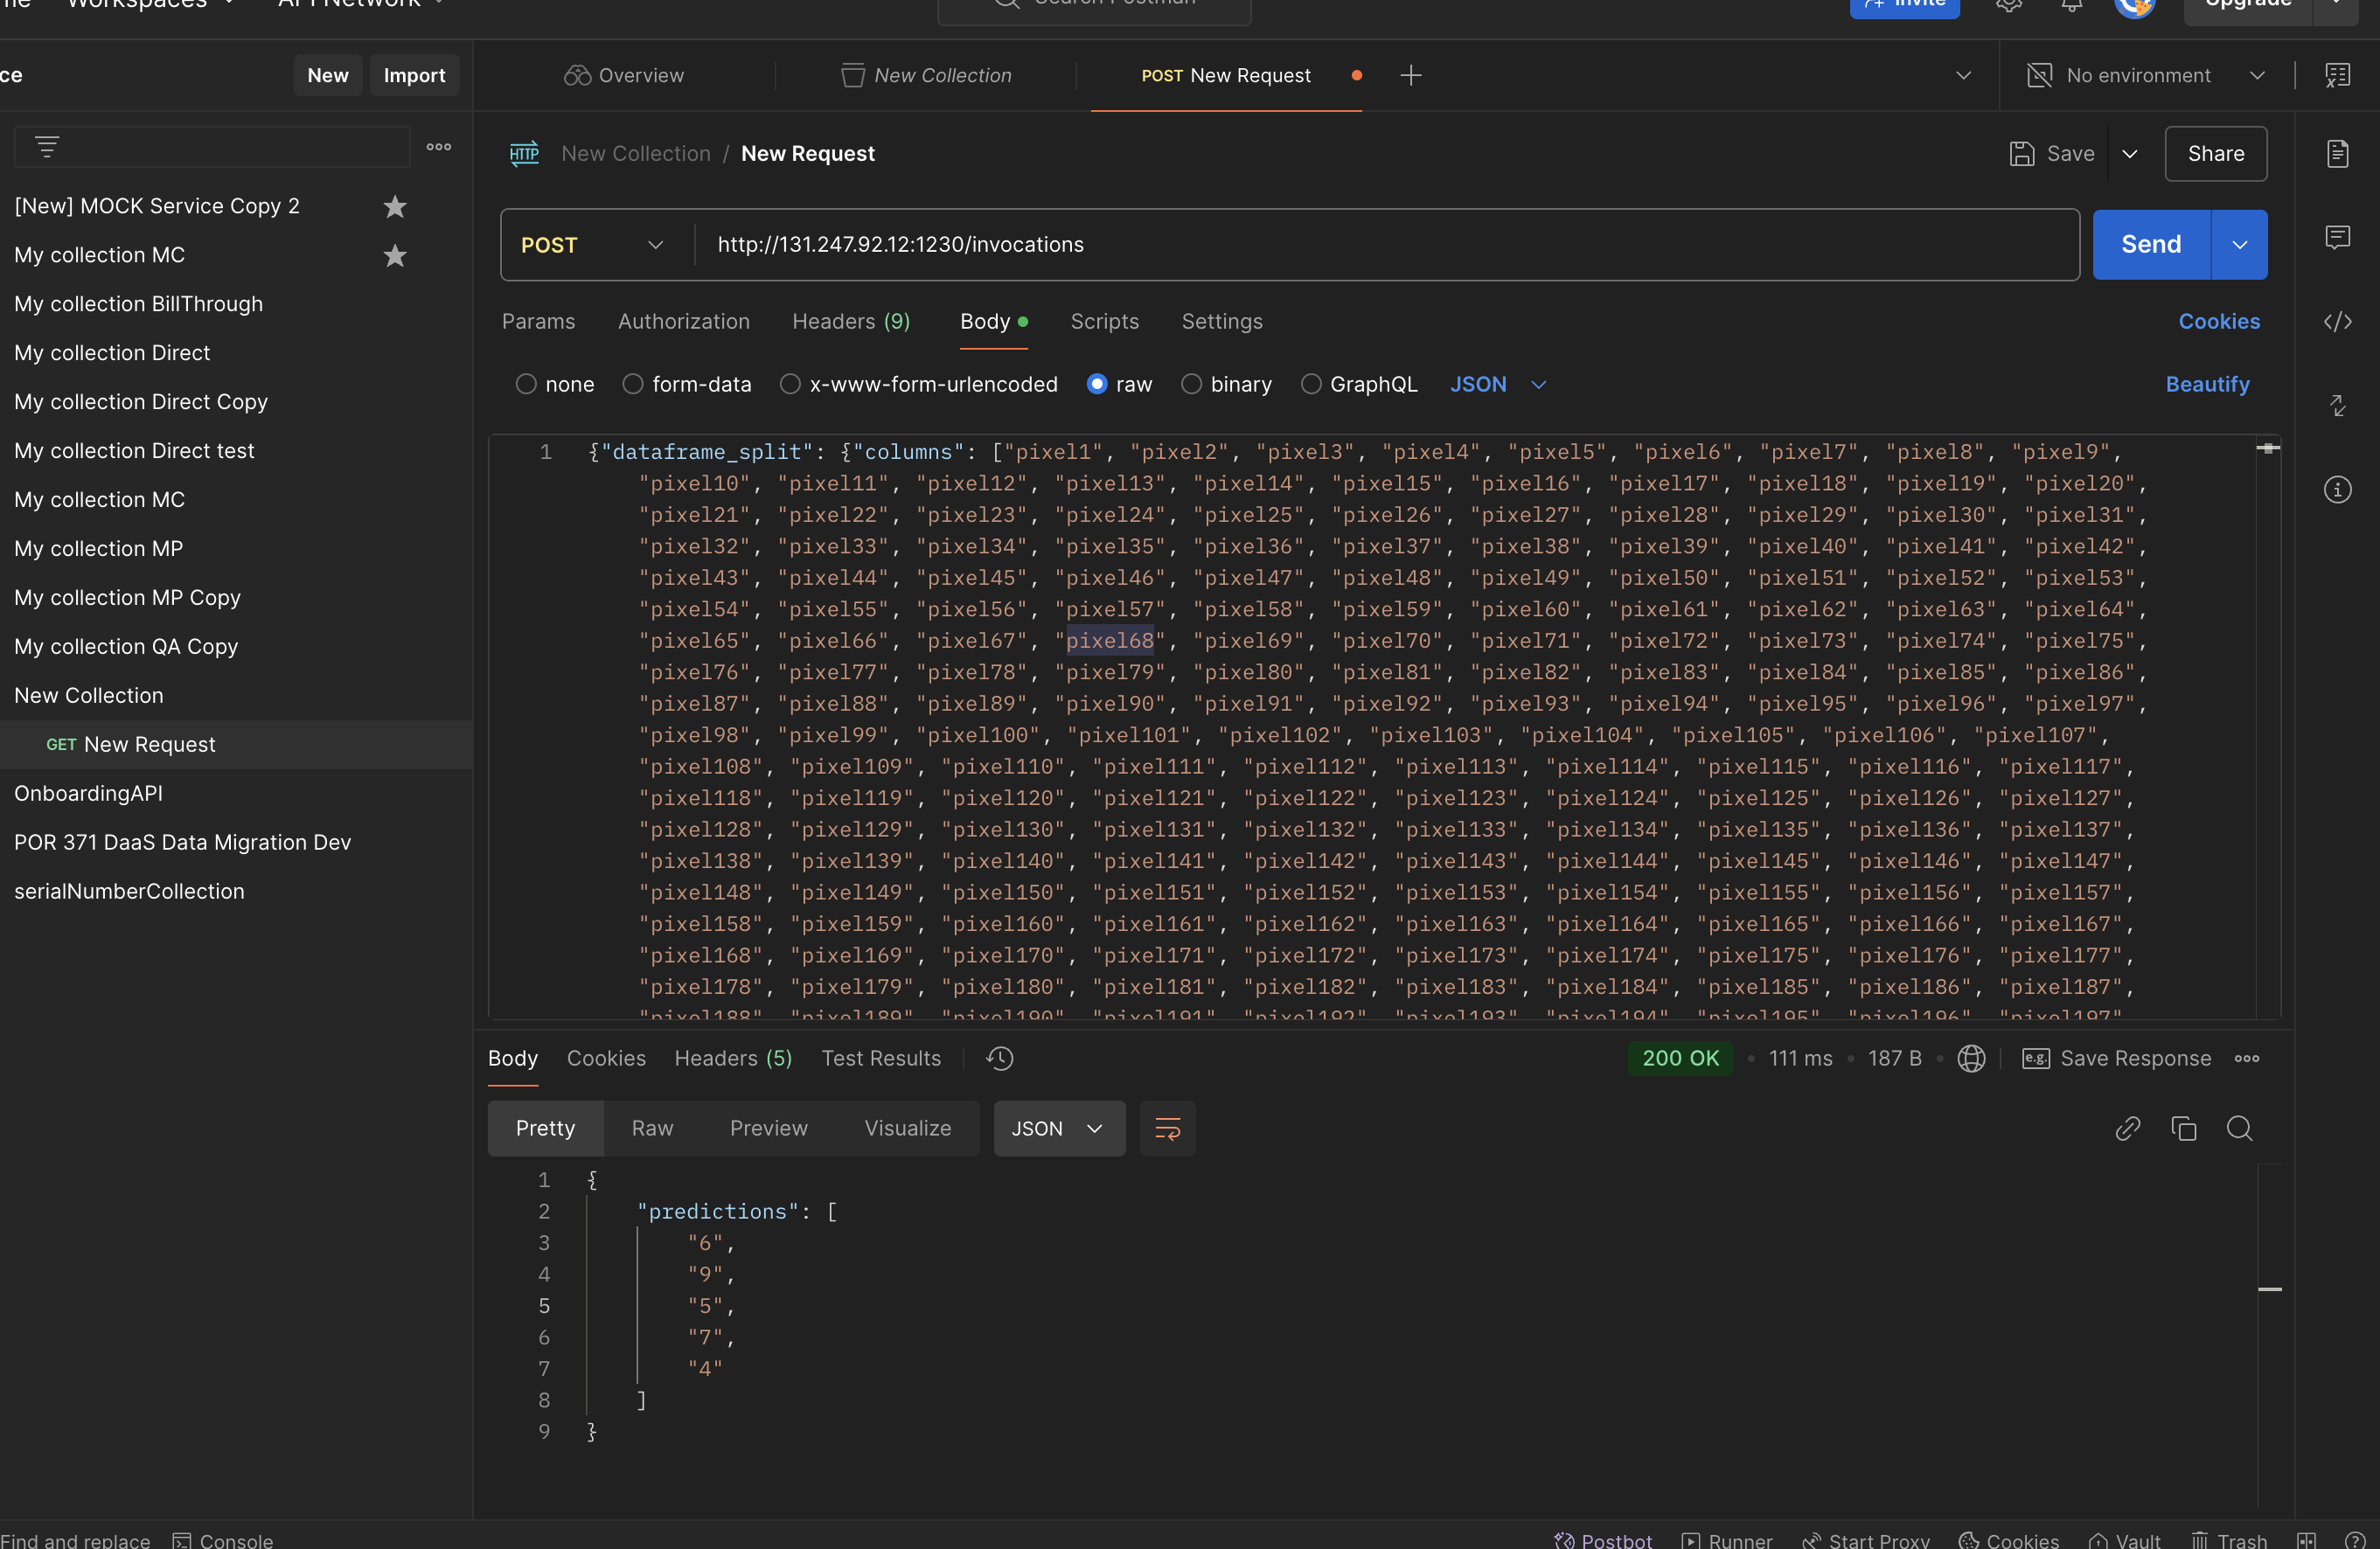

In [2]:
from IPython.display import Image, display

# Displaying an image from a file
display(Image(filename="C:/Users/ranil/Downloads/Screenshot 2024-11-03 at 10.34.49 PM (1).png"))